In [2]:
import tensorflow as tf
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(1234)

In [3]:
import sys
sys.path.insert(1,'/data/')
from data_utils import parse_imdb_sequence

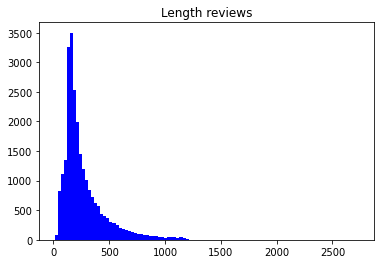

In [4]:
length_reviews = pickle.load(open('./data/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [5]:
full_dataset  = tf.data.TFRecordDataset('./data/train.tfrecords')
full_dataset  = full_dataset.shuffle(buffer_size=10000)

DATASET_SIZE  = sum(1 for _ in full_dataset)
print(DATASET_SIZE)

train_size = int(0.8 * DATASET_SIZE)
val_size   = int(0.2 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
val_dataset   = full_dataset.take(val_size)

train_dataset_size  = sum(1 for _ in train_dataset)
print(train_dataset_size)

val_dataset_size  = sum(1 for _ in val_dataset)
print(val_dataset_size)

train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))

val_dataset = val_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
val_dataset = val_dataset.padded_batch(128, padded_shapes=([None],[],[]))

test_dataset = tf.data.TFRecordDataset('./data/test.tfrecords')
DATASET_SIZE  = sum(1 for _ in test_dataset)
print(DATASET_SIZE)
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

2022-03-29 22:21:43.774193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 22:21:43.804910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 22:21:43.805375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 22:21:43.807260: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

25000
20000
5000
25000


In [ ]:
# Read the word vocabulary
word2idx = pickle.load(open('./data/word2idx.pkl', 'rb'))

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, test_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        test_acc = tf.keras.metrics.Accuracy('test_acc')
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        self.history['test_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break
                    
            for step, (X, y, seq_length) in enumerate(test_data):
                logits = self.predict(X, seq_length, False)
                preds = tf.argmax(logits, axis=1)
                test_acc(preds, y)
            self.history['test_acc'].append(test_acc.result().numpy())
            print('Test accuracy: ', self.history['test_acc'][-1])

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = './models_checkpoints/ImdbRNN1/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-1)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model1 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
lstm_model1.fit(train_dataset, val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model1)
save_path = checkpoint.save(checkpoint_directory)

##############################################################################################################

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-1)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model1 = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
ugrnn_model1.fit(train_dataset,  val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model1)
save_path = checkpoint.save(checkpoint_directory)

##############################################################################################################

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model1.history['train_acc'])), lstm_model1.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model1.history['eval_acc'])), lstm_model1.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_model1.history['train_acc'])), ugrnn_model1.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model1.history['eval_acc'])), ugrnn_model1.history['eval_acc'],
         label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();


/tmp/ipykernel_24286/2071740490.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:754: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:757: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(


Train accuracy at epoch 1:  0.49895
Eval accuracy at epoch 1:  0.4926
Train accuracy at epoch 2:  0.5035
Eval accuracy at epoch 2:  0.5038
Train accuracy at epoch 3:  0.4996
Eval accuracy at epoch 3:  0.501
Train accuracy at epoch 4:  0.50225
Eval accuracy at epoch 4:  0.503
Train accuracy at epoch 5:  0.49955
Eval accuracy at epoch 5:  0.5058
Train accuracy at epoch 6:  0.5007
Eval accuracy at epoch 6:  0.507
Train accuracy at epoch 7:  0.5014
Eval accuracy at epoch 7:  0.4922
Train accuracy at epoch 8:  0.49865
Eval accuracy at epoch 8:  0.5036


/tmp/ipykernel_13455/2071740490.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)


Train accuracy at epoch 1:  0.5166
Eval accuracy at epoch 1:  0.5198
Train accuracy at epoch 2:  0.55795
Eval accuracy at epoch 2:  0.55
Train accuracy at epoch 3:  0.58275
Eval accuracy at epoch 3:  0.5778
Train accuracy at epoch 4:  0.57965
Eval accuracy at epoch 4:  0.5814
Train accuracy at epoch 5:  0.63445
Eval accuracy at epoch 5:  0.6206
Train accuracy at epoch 6:  0.65475
Eval accuracy at epoch 6:  0.6626
Train accuracy at epoch 7:  0.6957
Eval accuracy at epoch 7:  0.6844
Train accuracy at epoch 8:  0.7013
Eval accuracy at epoch 8:  0.7026
Train accuracy at epoch 9:  0.72165
Eval accuracy at epoch 9:  0.7226
Train accuracy at epoch 10:  0.7182
Eval accuracy at epoch 10:  0.7154
Train accuracy at epoch 11:  0.75535
Eval accuracy at epoch 11:  0.7522
Train accuracy at epoch 12:  0.76385
Eval accuracy at epoch 12:  0.7674
Train accuracy at epoch 13:  0.81245
Eval accuracy at epoch 13:  0.811
Train accuracy at epoch 14:  0.8077
Eval accuracy at epoch 14:  0.8044
Train accuracy at 

/tmp/ipykernel_13455/2071740490.py:48: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)


Train accuracy at epoch 1:  0.5468
Eval accuracy at epoch 1:  0.5454
Train accuracy at epoch 2:  0.58975
Eval accuracy at epoch 2:  0.5882
Train accuracy at epoch 3:  0.60935
Eval accuracy at epoch 3:  0.6098
Train accuracy at epoch 4:  0.6563
Eval accuracy at epoch 4:  0.6592
Train accuracy at epoch 5:  0.75595
Eval accuracy at epoch 5:  0.7584
Train accuracy at epoch 6:  0.76295
Eval accuracy at epoch 6:  0.7648
Train accuracy at epoch 7:  0.7844
Eval accuracy at epoch 7:  0.7902
Train accuracy at epoch 8:  0.79905
Eval accuracy at epoch 8:  0.8112
Train accuracy at epoch 9:  0.8097
Eval accuracy at epoch 9:  0.808
Train accuracy at epoch 10:  0.8049
Eval accuracy at epoch 10:  0.8102
Train accuracy at epoch 11:  0.82035
Eval accuracy at epoch 11:  0.8254
Train accuracy at epoch 12:  0.82385
Eval accuracy at epoch 12:  0.8344
Train accuracy at epoch 13:  0.8309
Eval accuracy at epoch 13:  0.8352
Train accuracy at epoch 14:  0.82495
Eval accuracy at epoch 14:  0.8246
Train accuracy at

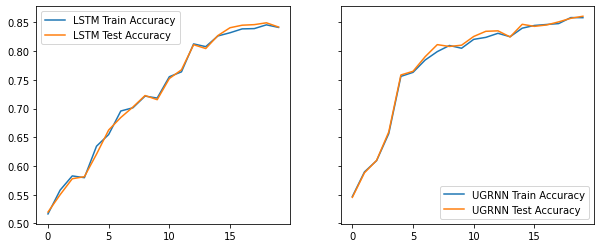

In [15]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN2/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-5)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model2 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
lstm_model2.fit(train_dataset, val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model2)
save_path = checkpoint.save(checkpoint_directory)


##############################################################################################################

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-5)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model2 = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
ugrnn_model2.fit(train_dataset,  val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model2)
save_path = checkpoint.save(checkpoint_directory)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model2.history['train_acc'])), lstm_model2.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model2.history['eval_acc'])), lstm_model2.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_model2.history['train_acc'])), ugrnn_model2.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model2.history['eval_acc'])), ugrnn_model2.history['eval_acc'],
         label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();

/tmp/ipykernel_13455/2071740490.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)


Train accuracy at epoch 1:  0.51105
Eval accuracy at epoch 1:  0.5094
Train accuracy at epoch 2:  0.51825
Eval accuracy at epoch 2:  0.5256
Train accuracy at epoch 3:  0.51855
Eval accuracy at epoch 3:  0.5188
Train accuracy at epoch 4:  0.52415
Eval accuracy at epoch 4:  0.5188
Train accuracy at epoch 5:  0.5225
Eval accuracy at epoch 5:  0.5286
Train accuracy at epoch 6:  0.51995
Eval accuracy at epoch 6:  0.5186
Train accuracy at epoch 7:  0.525
Eval accuracy at epoch 7:  0.5312
Train accuracy at epoch 8:  0.5167
Eval accuracy at epoch 8:  0.512
Train accuracy at epoch 9:  0.52745
Eval accuracy at epoch 9:  0.5248
Train accuracy at epoch 10:  0.52435
Eval accuracy at epoch 10:  0.5152
Train accuracy at epoch 11:  0.53085
Eval accuracy at epoch 11:  0.5254
Train accuracy at epoch 12:  0.49815
Eval accuracy at epoch 12:  0.4926
Test accuracy:  0.5

Total time taken (in seconds): 733.28


/tmp/ipykernel_13455/2071740490.py:48: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)


Train accuracy at epoch 1:  0.4983
Eval accuracy at epoch 1:  0.4986
Train accuracy at epoch 2:  0.5089
Eval accuracy at epoch 2:  0.5114
Train accuracy at epoch 3:  0.51245
Eval accuracy at epoch 3:  0.5136
Train accuracy at epoch 4:  0.5192
Eval accuracy at epoch 4:  0.53
Train accuracy at epoch 5:  0.52125
Eval accuracy at epoch 5:  0.5122
Train accuracy at epoch 6:  0.52775
Eval accuracy at epoch 6:  0.534
Train accuracy at epoch 7:  0.5277
Eval accuracy at epoch 7:  0.5268
Train accuracy at epoch 8:  0.526
Eval accuracy at epoch 8:  0.5234
Train accuracy at epoch 9:  0.5278
Eval accuracy at epoch 9:  0.5326
Train accuracy at epoch 10:  0.52705
Eval accuracy at epoch 10:  0.524
Train accuracy at epoch 11:  0.52985
Eval accuracy at epoch 11:  0.5288
Test accuracy:  0.52632

Total time taken (in seconds): 332.00


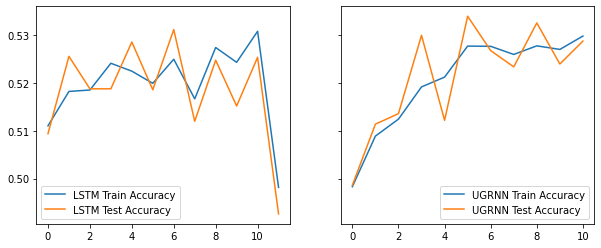

In [16]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = './models_checkpoints/ImdbRNN3/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-5)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model3 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
lstm_model3.fit(train_dataset, val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model3)
save_path = checkpoint.save(checkpoint_directory)

##############################################################################################################

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-5)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model3 = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
ugrnn_model3.fit(train_dataset,  val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model3)
save_path = checkpoint.save(checkpoint_directory)

##############################################################################################################

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model3.history['train_acc'])), lstm_model3.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model3.history['eval_acc'])), lstm_model3.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_model3.history['train_acc'])), ugrnn_model3.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model3.history['eval_acc'])), ugrnn_model3.history['eval_acc'],
         label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();


/tmp/ipykernel_13455/2071740490.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)


Train accuracy at epoch 1:  0.4996
Eval accuracy at epoch 1:  0.49
Train accuracy at epoch 2:  0.50045
Eval accuracy at epoch 2:  0.5
Train accuracy at epoch 3:  0.498
Eval accuracy at epoch 3:  0.5076
Train accuracy at epoch 4:  0.50125
Eval accuracy at epoch 4:  0.5052
Train accuracy at epoch 5:  0.49925
Eval accuracy at epoch 5:  0.5006
Train accuracy at epoch 6:  0.5001
Eval accuracy at epoch 6:  0.4998
Train accuracy at epoch 7:  0.50225
Eval accuracy at epoch 7:  0.495
Train accuracy at epoch 8:  0.4968
Eval accuracy at epoch 8:  0.4924
Test accuracy:  0.5

Total time taken (in seconds): 505.24


/tmp/ipykernel_13455/2071740490.py:48: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)


Train accuracy at epoch 1:  0.49895
Eval accuracy at epoch 1:  0.494
Train accuracy at epoch 2:  0.5002
Eval accuracy at epoch 2:  0.5086
Train accuracy at epoch 3:  0.4999
Eval accuracy at epoch 3:  0.4986
Train accuracy at epoch 4:  0.4994
Eval accuracy at epoch 4:  0.5048
Train accuracy at epoch 5:  0.50105
Eval accuracy at epoch 5:  0.493
Train accuracy at epoch 6:  0.50125
Eval accuracy at epoch 6:  0.4974
Train accuracy at epoch 7:  0.4999
Eval accuracy at epoch 7:  0.5038
Test accuracy:  0.5

Total time taken (in seconds): 215.59


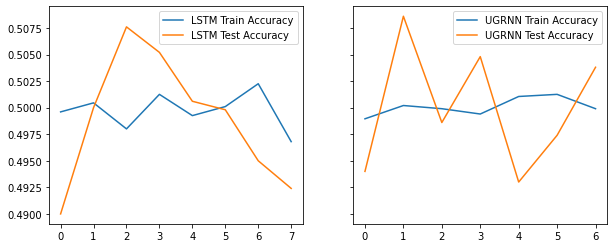

In [17]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = './models_checkpoints/ImdbRNN4/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-2)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model4 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
lstm_model4.fit(train_dataset, val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model4)
save_path = checkpoint.save(checkpoint_directory)

##############################################################################################################

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-2)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model4 = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

# Train model
time_start = time.time()
ugrnn_model4.fit(train_dataset,  val_dataset, test_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)


time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model4)
save_path = checkpoint.save(checkpoint_directory)

##############################################################################################################

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model4.history['train_acc'])), lstm_model4.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model4.history['eval_acc'])), lstm_model4.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_model4.history['train_acc'])), ugrnn_model4.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model4.history['eval_acc'])), ugrnn_model4.history['eval_acc'],
         label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();

In [18]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [19]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [20]:
sent_dict = {0: 'negative', 1: 'positive'}

In [21]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [22]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [23]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"

In [24]:
new_reviews = [review_score_10, review_score_4, review_score_1]
scores = [10, 4, 1]

In [25]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model1.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative
